In [14]:
# ===========================================
# 1. Librerías necesarias
# ===========================================
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta

In [7]:
# ===========================================
# 2. Descarga de datos DOGE-USD
# ===========================================
df = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31")
df = df[['Close']]
df.dropna(inplace=True)
df.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_3212\1292860115.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,DOGE-USD
Date,
2020-01-01,0.002033
2020-01-02,0.002009
2020-01-03,0.002145
2020-01-04,0.002241
2020-01-05,0.002419


In [8]:
# ===========================================
# 3. Preparar datos para RNN
# ===========================================
LOOKBACK = 30
DIAS_PRED = 6

scaler = MinMaxScaler()
precios_scaled = scaler.fit_transform(df[['Close']])

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)
    return X, y

X, y = create_sequences(precios_scaled, LOOKBACK)

In [9]:
# ===========================================
# 4. Construcción del modelo RNN
# ===========================================
N_NEURONAS = 128   # más neuronas para mejor capacidad de aprendizaje
EPOCHS = 150       # más épocas
BATCH_SIZE = 16
LR = 0.001

model = Sequential()
model.add(SimpleRNN(N_NEURONAS, activation='tanh', input_shape=(LOOKBACK,1)))
model.add(Dense(1))
optimizer = Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss='mse', metrics=['mape'])
model.summary()

c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# ===========================================
# 5. Entrenamiento
# ===========================================
history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)


Epoch 1/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037 - mape: 2957.6570
Epoch 2/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6176e-04 - mape: 1189.3595
Epoch 3/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7042e-04 - mape: 4727.4790
Epoch 4/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5591e-04 - mape: 1276.3696
Epoch 5/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4536e-04 - mape: 3737.1431
Epoch 6/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7308e-04 - mape: 4359.6079
Epoch 7/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6991e-04 - mape: 455.2878
Epoch 8/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2378e-04 - mape: 4557.4292
Epoch 9/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8700e-04 - mape: 588.3218
Epoch 10/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6003e-04 - mape: 4755.2754
Epoch 11/150
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8358e-04 - mape: 243.7875
Epoch 12/150
11

In [11]:
# ===========================================
# 6. Predicción futura (6 días)
# ===========================================
entrada = precios_scaled[-LOOKBACK:].reshape(1, LOOKBACK, 1)
predicciones_scaled = []

for _ in range(DIAS_PRED):
    pred = model.predict(entrada, verbose=0)
    predicciones_scaled.append(pred[0,0])
    # CORRECCIÓN: reshape a (1,1,1) para mantener compatibilidad
    entrada = np.append(entrada[:,1:,:], pred.reshape(1,1,1), axis=1)

predicciones = scaler.inverse_transform(np.array(predicciones_scaled).reshape(-1,1))


In [15]:
DIAS_PRED = 6

# Últimos datos escalados
entrada = precios_scaled[-LOOKBACK:].reshape(1, LOOKBACK, 1)
predicciones_scaled = []

for _ in range(DIAS_PRED):
    pred = model.predict(entrada, verbose=0)
    predicciones_scaled.append(pred[0,0])
    pred_reshaped = pred.reshape(1,1,1)  # Dimensiones correctas
    entrada = np.append(entrada[:,1:,:], pred_reshaped, axis=1)

# Volver a escala real
predicciones = scaler.inverse_transform(np.array(predicciones_scaled).reshape(-1,1))

# Fechas futuras
fechas_futuras = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=DIAS_PRED)
fechas_futuras = pd.to_datetime(fechas_futuras).normalize()

# Crear tabla de predicción
tabla_pred = pd.DataFrame({'Fecha': fechas_futuras, 'Predicción': predicciones.flatten()})

# Descargar valores reales y asegurarnos de que las columnas sean planas
df_future = yf.download(
    "DOGE-USD",
    start=str(fechas_futuras.min().date()),
    end=str((fechas_futuras.max() + pd.Timedelta(days=1)).date())
)

# Mantener solo columnas planas y resetear índice
df_future = df_future[['Close']].copy()
df_future = df_future.reset_index()
df_future.columns = ['Date', 'Close']  # aseguramos nombres planos

# Normalizar fechas
df_future['Date'] = pd.to_datetime(df_future['Date']).dt.normalize()
tabla_pred['Fecha'] = pd.to_datetime(tabla_pred['Fecha']).dt.normalize()

# Merge seguro
tabla_pred = pd.merge(
    tabla_pred,
    df_future,
    left_on='Fecha',
    right_on='Date',
    how='left'
).drop(columns='Date').rename(columns={'Close':'Real'})

C:\Users\ACER\AppData\Local\Temp\ipykernel_3212\1070517854.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_future = yf.download(
[*********************100%***********************]  1 of 1 completed


In [16]:
# ===========================================
# 8. Calcular MAPE
# ===========================================
def calculate_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))*100

mape_pred = calculate_mape(tabla_pred['Real'].values, tabla_pred['Predicción'].values)
print(f"\nMAPE predicción 6 días: {mape_pred:.2f}%")



MAPE predicción 6 días: 6.31%


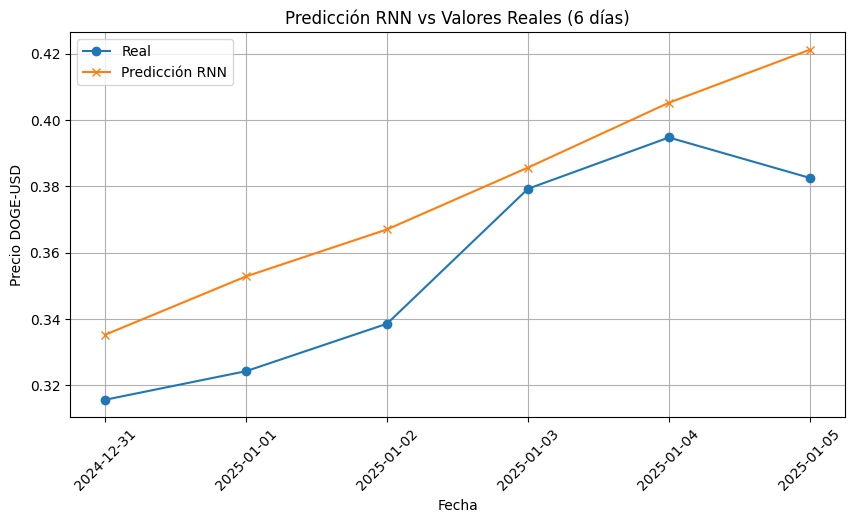

In [17]:
# ===========================================
# 9. Gráfico
# ===========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(tabla_pred['Fecha'], tabla_pred['Real'], marker='o', label='Real')
plt.plot(tabla_pred['Fecha'], tabla_pred['Predicción'], marker='x', label='Predicción RNN')
plt.title("Predicción RNN vs Valores Reales (6 días)")
plt.xlabel("Fecha")
plt.ylabel("Precio DOGE-USD")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


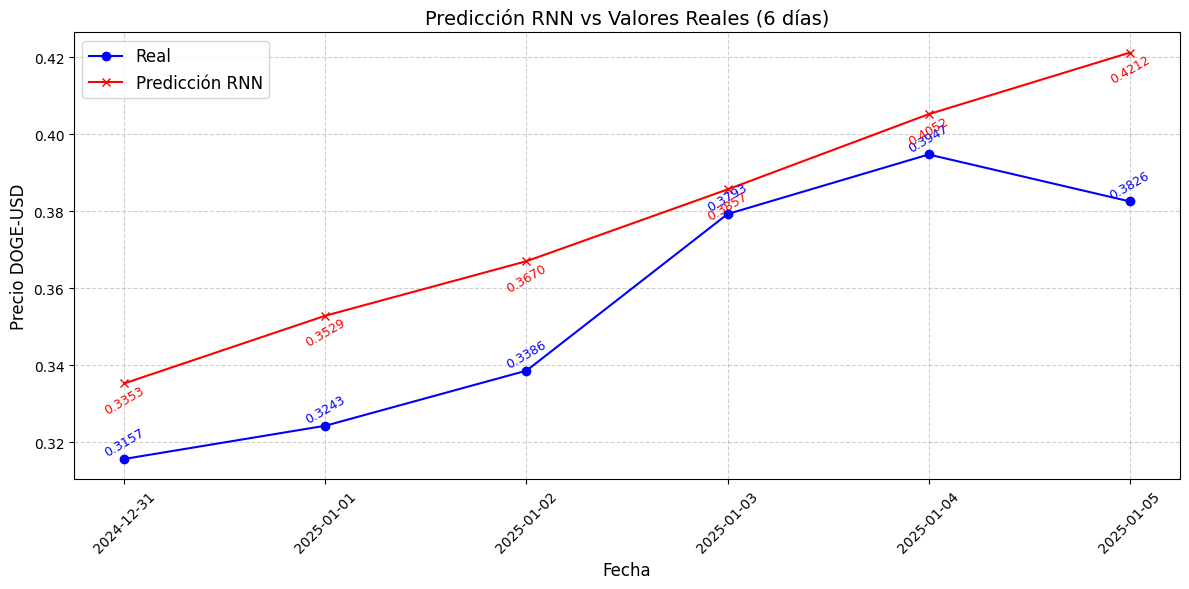

In [31]:
# Gráfico mejorado con anotaciones

plt.figure(figsize=(12,6))

# Graficar valores reales
plt.plot(tabla_pred['Fecha'], tabla_pred['Real'], marker='o', label='Real', color='blue')
# Graficar predicciones
plt.plot(tabla_pred['Fecha'], tabla_pred['Predicción'], marker='x', label='Predicción RNN', color='red')

# Añadir anotaciones con los valores
for x, y_real, y_pred in zip(tabla_pred['Fecha'], tabla_pred['Real'], tabla_pred['Predicción']):
    plt.text(x, y_real, f'{y_real:.4f}', fontsize=9, ha='center', va='bottom', color='blue', rotation=30)
    plt.text(x, y_pred, f'{y_pred:.4f}', fontsize=9, ha='center', va='top', color='red', rotation=30)

plt.title("Predicción RNN vs Valores Reales (6 días)", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio DOGE-USD", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [18]:
# ===========================================
# 10. Mostrar tabla final
# ===========================================
print("\n📊 Tabla de predicciones vs reales (6 días):")
print(tabla_pred)


📊 Tabla de predicciones vs reales (6 días):
       Fecha  Predicción      Real
0 2024-12-31    0.335298  0.315681
1 2025-01-01    0.352881  0.324306
2 2025-01-02    0.367033  0.338610
3 2025-01-03    0.385674  0.379279
4 2025-01-04    0.405214  0.394746
5 2025-01-05    0.421193  0.382563


In [28]:

# Valores de predicción
pred = tabla_pred['Predicción'].values

# Calcular cambio total y pendiente promedio
cambio_total = pred[-1] - pred[0]
pendiente_promedio = np.mean(np.diff(pred))

print(f"Cambio total en 6 días: ${cambio_total:.4f}")
print(f"Pendiente promedio diaria: ${pendiente_promedio:.4f}")

# Interpretación de tendencia
if pendiente_promedio > 0:
    print("Tendencia general: ALCISTA (al alza)")
elif pendiente_promedio < 0:
    print("Tendencia general: BAJISTA (a la baja)")
else:
    print("Tendencia general: ESTABLE")


Cambio total en 6 días: $0.0859
Pendiente promedio diaria: $0.0172
Tendencia general: ALCISTA (al alza)


In [29]:
# ===========================================

# Supongamos que predicciones_inv es tu array con los 6 valores predichos
predicciones_6dias = tabla_pred['Predicción'].values

# Tendencia general (%)
tendencia = (predicciones_6dias[-1] - predicciones_6dias[0]) / predicciones_6dias[0] * 100

# Volatilidad (desviación estándar)
volatilidad = np.std(predicciones_6dias)

print(f"Tendencia general: {tendencia:.2f}%")
print(f"Volatilidad: {volatilidad:.4f}")


Tendencia general: 25.62%
Volatilidad: 0.0296
